*Scenario 4*: Check the hyperparameters in the successful fits.

Calculate the cutoff for a successful fit within a confidence region, based on the assumption that the difference of the nllh's of the true and optimal parameter is chi^2 distributed with n_theta degrees of freedom.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sys
from pathlib import Path
sys.path.append(str(Path(".").resolve().parent))

from helpers_boehm import load_exp_summary

dir_pipeline = Path(".").resolve().parents[1]
dir_5 = dir_pipeline / "5_optimisation"
output_path = Path(".") / "hyperparameters"
output_path.mkdir(exist_ok=True)

In [2]:
likelihood: str = "negLL_obs_trainval"
percentile: float = 95

SIMULTANEOUS = "simultaneous"
POINTWISE = "pointwise"
cr_option = POINTWISE

In [3]:
# import the results
problem_name = "Boehm_observable_ab_ratio"
experiment_name_low = "2024_08_11_" + problem_name
experiment_name_high = "2024_11_20_" + problem_name

summary = pd.concat(
    [
        load_exp_summary(dir_5 / experiment_name_low),
        load_exp_summary(dir_5 / experiment_name_high),
    ]
).reset_index(drop=True)

summary.sort_values(by=likelihood)

,ude_nr,problem_name,noise_level,sparsity,hidden_layers,hidden_neurons,act_fct,nn_input_normalization,startpoint_method,startpoint_id,...,sd_pSTAT5B_rel,sd_rSTAT5A_rel,mae_obs_train,nmae_obs_train,mae_obs_val,mae_obs_trainval,nmae_obs_val,nmae_obs_trainval,mae_obs_test,nmae_obs_test
10449,10451,boehm_observable_ab_ratio,-,16,2,5,tanh,0,lhs,10451,...,6.274806,0.253342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14484,14487,boehm_observable_ab_ratio,-,16,1,5,tanh,0,lhs,14487,...,6.564127,0.363035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15920,923,boehm_observable_ab_ratio,-,16,1,10,relu,0,lhs,923,...,5.952393,0.432028,2.600967,0.047143,4.497825,2.956628,0.071363,0.052208,NaN,NaN
14208,14211,boehm_observable_ab_ratio,-,16,2,5,tanh,0,lhs,14211,...,6.502509,0.527552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2659,2661,boehm_observable_ab_ratio,-,16,1,3,relu,0,lhs,2661,...,6.967945,0.549783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29708,14713,boehm_observable_ab_ratio,-,16,3,10,tanh,0,lhs,14713,...,0.000012,520.684090,51.627613,4223.320833,56.543883,52.549414,2699.246588,3780.330015,NaN,NaN
14831,14834,boehm_observable_ab_ratio,-,16,1,10,swish,0,lhs,14834,...,0.000011,12.692248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29829,14834,boehm_observable_ab_ratio,-,16,1,10,swish,0,lhs,14834,...,0.000011,12.692248,40.977463,82.997869,45.047319,41.740561,96.827781,85.424547,NaN,NaN
29929,14934,boehm_observable_ab_ratio,-,16,2,10,relu,1,lhs,14934,...,48518.090280,0.000015,45.914286,14112.969893,49.067537,46.505520,16026.118577,14459.393979,NaN,NaN


In [4]:
hps_categorical = ['hidden_layers', 'hidden_neurons', 'act_fct', 'nn_input_normalization']

# add reg bins
bins_reg = [-1,  1e-3,    1e-2,  1e-1,   1, 10, 100, 1000]
labels_reg = ["0",  "<0.01", "<0.1", "<1", "<10", "<100", "<1000"]
summary["regbin"] = pd.cut(summary['λ_reg'], bins=bins_reg, labels=labels_reg)

# add learning rate bins
bins_lr = [1e-4,   1e-3,    1e-2,   1e-1]
labels_lr = ["<0.001", "<0.01", "<0.1"]
summary["lr_bin"] = pd.cut(summary['lr_adam'], bins=bins_lr, labels=labels_lr)

# add a column indicating ANN width x depth
summary["ann_dim"] = summary[
    "hidden_layers"
].astype(str) + " x " + summary[
    "hidden_neurons"
].astype(str)

hps_categorical += ["regbin", "lr_bin", "ann_dim"]

summary["regbin"].value_counts()

regbin
0        6098
<1000    3990
<1       3990
<100     3988
<0.1     3988
<0.01    3971
<10      3971
Name: count, dtype: int64

In [5]:
# optimal point as base:
fval_opt = summary[likelihood][0]
if cr_option == SIMULTANEOUS:
    # degrees of freedom is equal to the number of parameters
    df = 9 + 117  # theta_MM + theta_ANN
elif cr_option == POINTWISE:
    # degrees of freedom is equal to 1
    df = 1

range = chi2.ppf(q=percentile / 100, df=df)

cut_off = fval_opt + range

print('optimal fval ', fval_opt)
print('threshold    ', cut_off)
print('# within CR: ', summary[summary[likelihood] < cut_off].shape[0], " / ", summary.shape[0])

optimal fval  429.698712997713
threshold     433.54017181840715
# within CR:  22721  /  29996


In [6]:
# best = summary.iloc[:]    # to do: visual assessment
best = summary[summary[likelihood] < cut_off]

best

,ude_nr,problem_name,noise_level,sparsity,hidden_layers,hidden_neurons,act_fct,nn_input_normalization,startpoint_method,startpoint_id,...,nmae_obs_train,mae_obs_val,mae_obs_trainval,nmae_obs_val,nmae_obs_trainval,mae_obs_test,nmae_obs_test,regbin,lr_bin,ann_dim
0,1,boehm_observable_ab_ratio,-,16,3,10,swish,1,lhs,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<0.1,<0.001,3 x 10
1,2,boehm_observable_ab_ratio,-,16,1,5,rbf,1,lhs,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<0.1,<0.1,1 x 5
2,3,boehm_observable_ab_ratio,-,16,3,10,rbf,0,lhs,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<0.001,3 x 10
3,4,boehm_observable_ab_ratio,-,16,2,5,tanh,1,lhs,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<0.001,2 x 5
4,5,boehm_observable_ab_ratio,-,16,1,10,tanh,1,lhs,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<0.001,1 x 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,14993,boehm_observable_ab_ratio,-,16,1,5,rbf,0,lhs,14993,...,7.741188e+11,57.291831,53.294655,6.155715e+11,7.363263e+11,NaN,NaN,<100,<0.01,1 x 5
29989,14994,boehm_observable_ab_ratio,-,16,1,3,relu,1,lhs,14994,...,1.072156e+12,45.480648,42.162237,3.808856e+11,7.873379e+11,NaN,NaN,<10,<0.01,1 x 3
29991,14996,boehm_observable_ab_ratio,-,16,4,10,rbf,0,lhs,14996,...,7.740862e+11,57.289096,53.291919,6.155556e+11,7.362982e+11,NaN,NaN,<1000,<0.001,4 x 10
29993,14998,boehm_observable_ab_ratio,-,16,2,5,rbf,1,lhs,14998,...,7.741207e+11,57.291826,53.294649,6.155763e+11,7.363290e+11,NaN,NaN,<100,<0.1,2 x 5


/tmp/ipykernel_1187341/2464933811.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1187341/2464933811.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1187341/2464933811.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1187341/2464933811.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1187341/2464933811.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


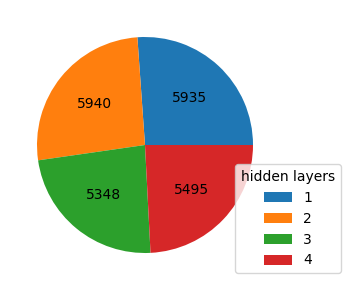

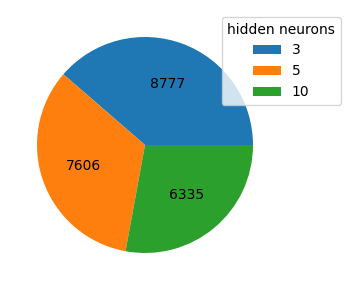

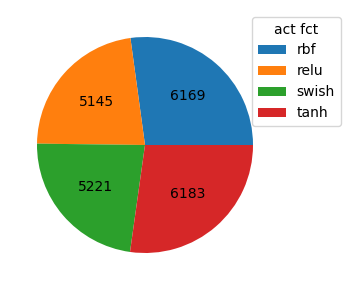

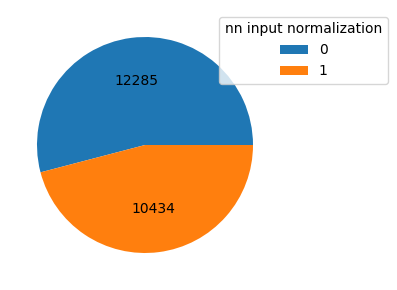

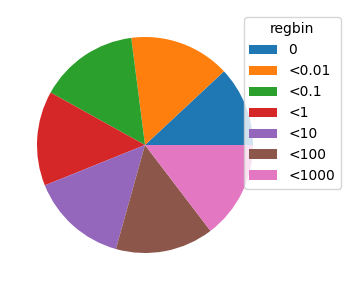

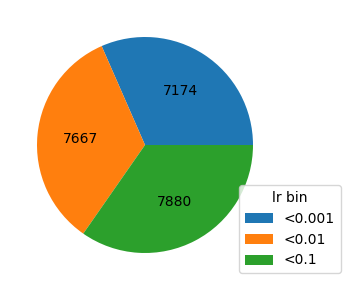

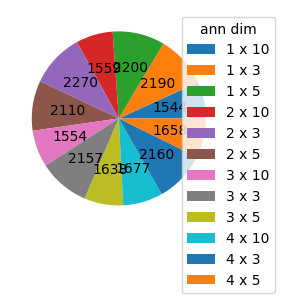

In [7]:
for hp in hps_categorical:
    fig, ax = plt.subplots(figsize=(5, 3))
    # separate pie for regularisation strength because there were more starts with lambda 0
    if hp == "regbin":
        d = pd.DataFrame([summary["regbin"].value_counts(), best[hp].value_counts().sort_index()], index=["Total", "Success"]).T.sort_index()
        d["Anteil"] = d["Success"] / d["Total"]
        wedges, texts = ax.pie(d.Anteil)
        ax.legend(
            wedges, d.index,
            title=d.index.name.replace("_", " "),
            bbox_to_anchor=(0.75, 0, 0.5, 1)
        )
        
    else:
        # calc and sort the # fits/hp setting
        hp2plot = best[hp].value_counts().sort_index()

        def absolute_value(val):
            a  = int(val/100.*hp2plot.values.sum())
            return a

        wedges, texts, autotexts = ax.pie(
            hp2plot.values, autopct=absolute_value,
        )
        ax.legend(
            wedges, hp2plot.index,
            title=hp2plot.index.name.replace("_", " "),
            bbox_to_anchor=(0.75, 0, 0.5, 1)
        )
    fig.show()
    fig.tight_layout()
    fig.savefig(output_path / f"pie_{hp}.svg", transparent=True)